In [2]:
#Imports
!pip install pandas
!pip install optuna
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.4 MB/s eta 0:00:00


In [3]:
import time

In [4]:
from sklearn.experimental import enable_iterative_imputer, enable_halving_search_cv
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.model_selection import GridSearchCV, KFold, PredefinedSplit, RandomizedSearchCV, HalvingGridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler
import optuna
import pickle
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [5]:
rs = 100505730

# First assigment: PREDICTING WIND ENERGY PRODUCTION WITH SCIKIT-LEARN

AUTHORS:
- Sara de la Sota Alonso (NIA 100505730)
- María Garcia Fraile (NIA 100429121)



In [6]:
# We have used Google Drive to get the file
#from google.colab import drive
#drive.mount('/content/drive')
#PATH = '/content/drive/MyDrive/ML1/'

Mounted at /content/drive


In [41]:
#dataset = pd.read_csv(PATH+'wind_available.csv.gzip', compression="gzip")
dataset = pd.read_csv('wind_available.csv.gzip', compression="gzip")

dataset.head()
dataset.columns
df = dataset

# Exploratory data analysis
The dataset contains meteorological variables from 25 different locations near Sotavento. To approach the problem we have explore the dataset, explore the target variable and identify potential problems before constructing a model.

### Data size
The data set has 4748 instances and 555 features including the target energy.

In [42]:
#Size of the data
num_rows, num_columns = dataset.shape
print(f"Number of Istances: {num_rows}")
print(f"Number of Features: {num_columns}")

Number of Istances: 4748
Number of Features: 555


### Variable types
We wil detect wich features are categorical and wich are continuous. There are 4 categorical variables all refered to the time that are the year, month, day and hour of the observations. All the other variables are continuous. Since the aim of this project is to estimate the energy wich is continuous we have a regression problem.

In [9]:
#Detect with features are categorical
unique_values={}
for col in df:
  content= df[col].unique()
  content = content.tolist()
  unique_values[str(col)]=content
for i in unique_values:
  if len(unique_values[i])<35:
    print(i,unique_values[i])

year [2005, 2006, 2007, 2008, 2009]
month [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
day [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 1]
hour [18, 0, 6, 12]


### Check for constant columns
There are no constant columns, therefore all features can potentiallly be useful to make predictions.

In [10]:
# Check for constant columns
constant_columns = [col for col in df.columns if df[col].nunique() == 1]
if constant_columns!=[]:
  print("Constant columns:\n", constant_columns)
else:
  print("There are no constant columns.")


There are no constant columns.


### Target variable
Firstly, we will visualize the target distribution to understand the behaviour of the variable energy and its distribution, look for outliers or interesting patterns and set a performance benchmark. Then, we will study the correlation between the predictors and the target in order to identify the most influential or relevant predictors that significantly impact the behavior or outcome of the target variable and those variables that might not be relevant

In [11]:
target= df['energy']

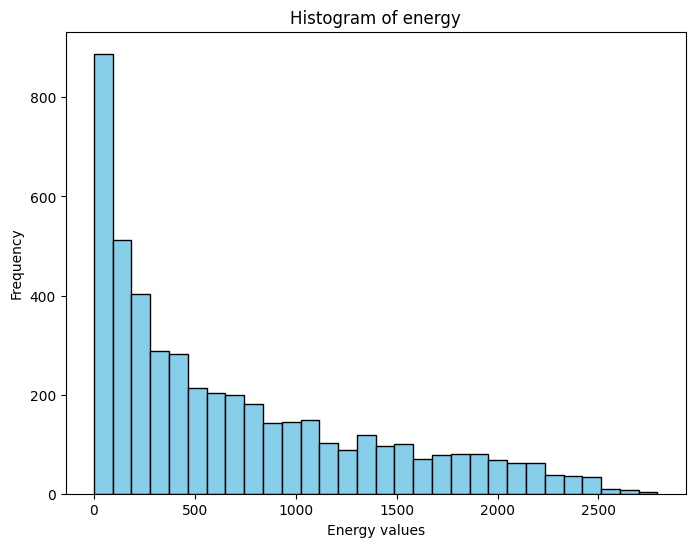

In [12]:
# Plotting a histogram
plt.figure(figsize=(8, 6))
plt.hist(target, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of energy')
plt.xlabel('Energy values')
plt.ylabel('Frequency')
plt.show()

In the histogram above we can see a right-skewed distribution where the instances tak values between 0 and 3000. The majority class is near to zero and then the frequency starts decreasing up to the last value.

Regarding the correlations, in the table below we can see the value for all the features. Moreover we have plotted the 30 highest correlated features and the 30 lower. The highest feature is p55.162, the vertical integral of divergence of kinetic energy, with a coefficient slighlty bigger than 0.4. On the contrary, the lowest correlated feature, near to 0 is p55.162, the vertical integral of water vapour. This information could be relevant to perform feature selection.

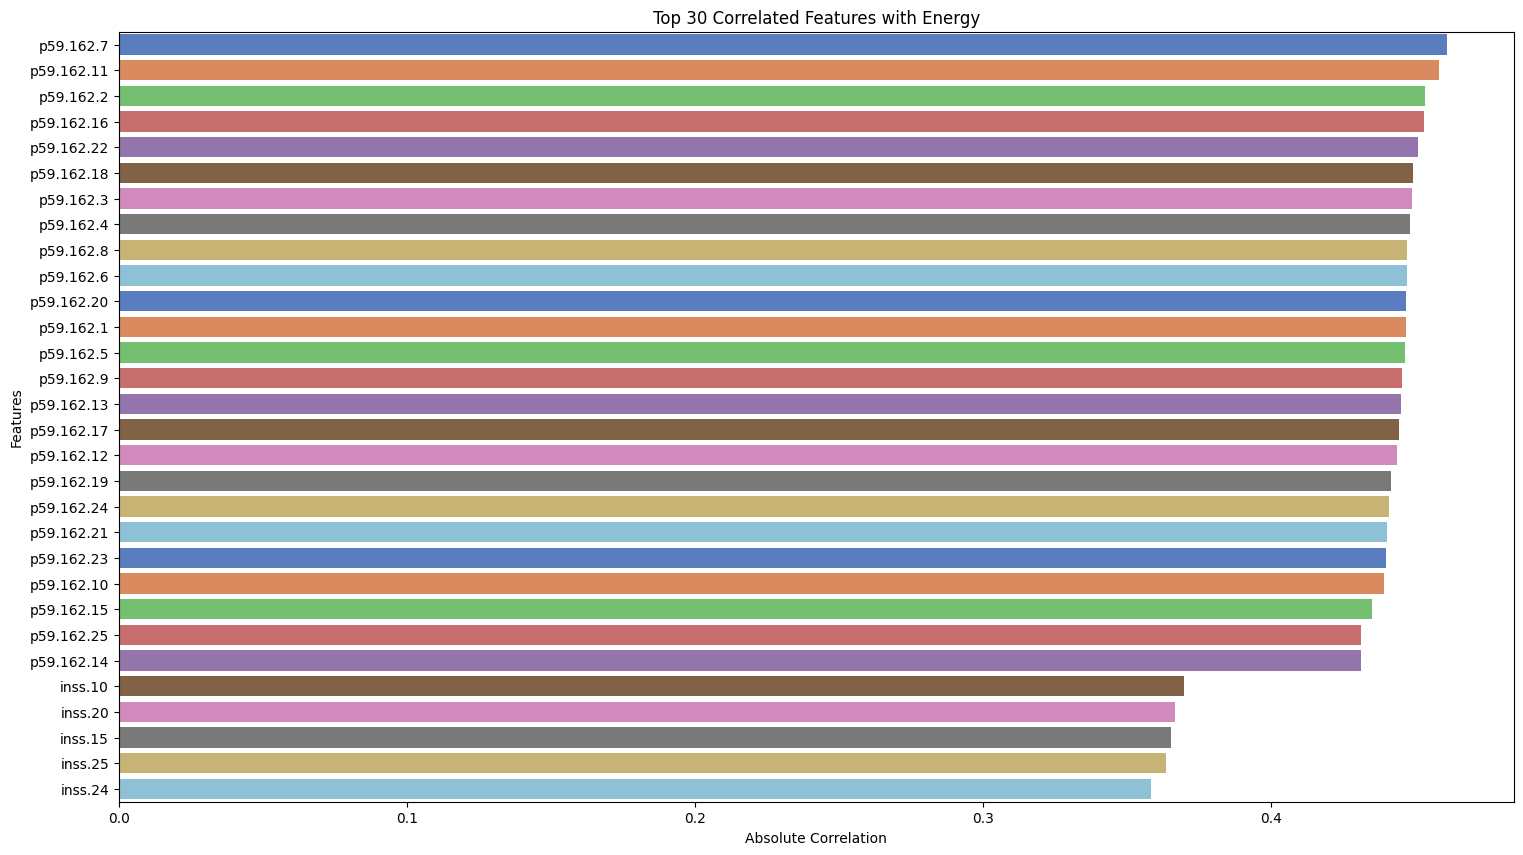

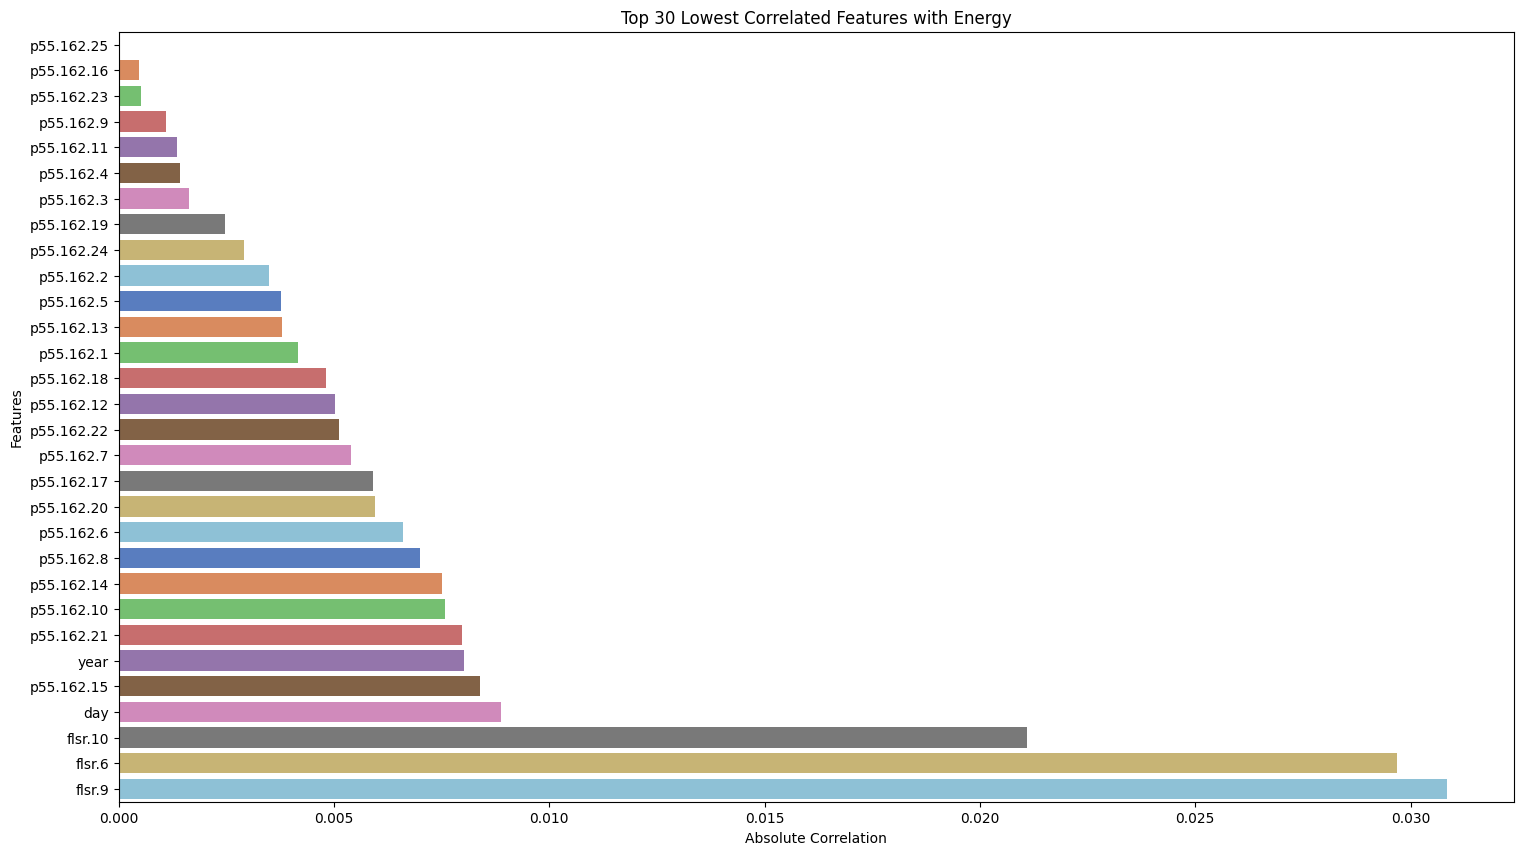

In [14]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Extract correlations of other features with the target variable 'energy'
target_correlations = correlation_matrix['energy'].drop('energy')

# Sort correlations in descending order to get the top N correlated features
top_n = 30  # Change this value to display a different number of top features
top_correlations = target_correlations.abs().nlargest(top_n)

# Sort correlations in ascending order to get the top N lowest correlated features
top_lowest_n = 30  # Change this value to display a different number of bottom features
top_lowest_correlations = target_correlations.abs().nsmallest(top_lowest_n)

# Plotting bar plot for top N correlated features
plt.figure(figsize=(18, 10))
sns.barplot(x=top_correlations.values, y=top_correlations.index, palette='muted')
plt.title(f'Top {top_n} Correlated Features with Energy')
plt.xlabel('Absolute Correlation')
plt.ylabel('Features')
plt.show()

# Plotting bar plot for top N lowest correlated features
plt.figure(figsize=(18, 10))
sns.barplot(x=top_lowest_correlations.values, y=top_lowest_correlations.index, palette='muted')
plt.title(f'Top {top_lowest_n} Lowest Correlated Features with Energy')
plt.xlabel('Absolute Correlation')
plt.ylabel('Features')
plt.show()

In [15]:
# Display correlation table for the target variable 'energy'
print("Correlation Table for 'energy':")
correlation = pd.DataFrame(correlation_matrix['energy'])
correlation

Correlation Table for 'energy':


,energy
energy,1.000000
year,0.008027
month,0.033065
day,-0.008878
hour,-0.033962
...,...
v100.21,0.290507
v100.22,0.299461
v100.23,0.302173
v100.24,0.313052


### Missing values
Most machine learning algorithms have problems working with missing values. Moreover if a feature has a high number of them, we would need to remove that column, because the information quality is not good enough.
Below we can see a table with the number of missing values per column. Moreover, all rows contain a null value, so removing rows is not an option. We will approach this problem by substituting missing values with imputation.

In [16]:
# Count the null values for each feature (column)
null_values_per_feature = df.isnull().sum()

# Convert the Series to a DataFrame
null_values_table = pd.DataFrame(null_values_per_feature, columns=['Null Values'])

# Sort the DataFrame by the number of null values in descending order
null_values_table = null_values_table.sort_values(by='Null Values', ascending=False)

# Display the result
print("Number of null values for each feature:")
print(null_values_table)


Number of null values for each feature:
           Null Values
lai_hv.13          964
fsr.3              957
v10n.24            947
stl3.20            946
lai_hv.19          942
...                ...
hour                 0
year                 0
day                  0
month                0
energy               0

[555 rows x 1 columns]


In the next sections we will need to approach these missing values by using different methods of imputation.

In the following table we see a general description of all the variables in the data frame.

In [17]:
df.describe()

,energy,year,month,day,hour,p54.162.1,p54.162.2,p54.162.3,p54.162.4,p54.162.5,...,v100.16,v100.17,v100.18,v100.19,v100.20,v100.21,v100.22,v100.23,v100.24,v100.25
count,4748.000000,4748.000000,4748.000000,4748.000000,4748.000000,4.376000e+03,4.287000e+03,4.485000e+03,4.434000e+03,4.259000e+03,...,4140.000000,4181.000000,4018.000000,3816.000000,4480.000000,4487.000000,4361.000000,4179.000000,4169.000000,4312.000000
mean,693.126247,2006.628475,6.628054,15.652485,9.123842,2.512664e+06,2.504671e+06,2.497395e+06,2.489648e+06,2.481708e+06,...,0.230065,0.277537,0.359449,0.438263,0.406071,0.225057,0.260836,0.280071,0.332205,0.404362
std,665.531609,1.414856,3.475914,8.844734,6.755085,4.498680e+04,4.519397e+04,4.504295e+04,4.483586e+04,4.460474e+04,...,4.902399,4.813315,4.666727,4.493713,4.342197,4.869798,4.725219,4.569511,4.442757,4.314635
min,0.010000,2005.000000,1.000000,1.000000,0.000000,2.380562e+06,2.373125e+06,2.365683e+06,2.358246e+06,2.350809e+06,...,-13.737945,-13.359267,-12.980589,-12.601412,-12.222734,-13.712999,-13.326339,-11.274292,-12.552518,-12.165857
25%,144.170000,2005.000000,4.000000,8.000000,6.000000,2.481905e+06,2.473722e+06,2.466373e+06,2.458621e+06,2.451135e+06,...,-3.572133,-3.464741,-3.239355,-3.020580,-2.933020,-3.528852,-3.393895,-3.224513,-3.068601,-2.864918
50%,465.305000,2006.000000,7.000000,16.000000,12.000000,2.513508e+06,2.505370e+06,2.498471e+06,2.490711e+06,2.482535e+06,...,-0.515392,-0.450284,-0.387420,-0.180619,-0.237745,-0.507160,-0.464253,-0.385424,-0.329047,-0.261194
75%,1089.375000,2007.000000,10.000000,23.000000,18.000000,2.548502e+06,2.540545e+06,2.533515e+06,2.525281e+06,2.517041e+06,...,3.732389,3.668777,3.663663,3.606537,3.467963,3.697215,3.612399,3.489915,3.454242,3.400235
max,2792.550000,2009.000000,12.000000,31.000000,18.000000,2.604194e+06,2.596310e+06,2.588421e+06,2.580532e+06,2.572648e+06,...,17.730758,17.229346,16.774832,16.366718,15.959103,17.571603,17.080170,16.588237,16.096804,15.681705


## Initial plan of action
Here we show how we have orginzed and approached this project.

0. Establishing inner and outer evaluation methods.

1. Assuring imputation improves performance.
  * Compare a default imputation strategy (simple imputation with median strategy) to imputing the data set with 0 values.

2. Feature selection.
  * We will employ simple imputation with median strategy and experiment with several data sets.
  * Apply different methods select the best data set.

3. Gridsearch pipeline for each method.
  * First setp involves the chosing of the imputation method, and the subsequent step involves the regressor.
  * After establishing the range of search of the corresponding parameters, we will develop distinct pipelines for each method under consideration (Decision tree, Knn regressor, Gradient Boosting and Random Forest).
  * Select the best method based on the median absolute error and analize timing.

4. Hyperparameter optimization of the slected method.
  * We will create a pipeline for the three HPO methods (Random search, Halving search and Optuna) for the selected method.
  * Analize the parameters obtained and the time of execution.

5. Selecting the final model.
  * Estimate the accuracy of the final model using the outer evaluation.
  * Train the final model and make predictions using the competition data set.

Note: In order to efficiently save our results we created an excel file where we would save the parameter results as well as the time of execution of each method. All results are included in the conclusion sections delivered in tables, so we can easily compare all the results.

Changes of the plan: we have decided to do HPO with Random search, Halving search and Optuna for the best two models obtained in the Gridsearch section.

##Inner and Outer evaluation
 The dataset spans five years from 2005 to 2009, and for training purposes, we will utilize data from the first four years. For the outer evaluation we will use the data from 2009 as testing data to estimate future performance. This temporal split ensures that the model is tested on a realistic scenario, enhancing its reliability in forecasting energy production at the Sotavento during all seasons of the year.

 In order to evaluate the machine learning model's performance during the training phase we will split the training set in train-train and train-validation, to keep the realistic scenario we will have the data from years 2005, 2006 and 2007 for training and 2008 for validation porpuses.

 The metric we will be using for evaluating model's performances is the median absolute error since it is robust against outliers.

We will scale the data we will be using to train the models, since features with larger scales can dominate the learning process, leading to suboptimal model performance. In order to avoid the influence of outliers we have decided to use the Robust scaler.

In [43]:
column_names = dataset.columns.to_list()
year_column_index = np.where(np.array(column_names) == 'year')[0][0]

dataset = dataset.to_numpy()
# Separating the dataset based on the 'year' column
train_data = dataset[dataset[:, year_column_index] < 2009]
train_train_data = dataset[dataset[:, year_column_index] < 2008]  # Training data (years 2005-2008)
val_data = dataset[(dataset[:, year_column_index] == 2008)] # Validation data (year 2009)
test_data = dataset[dataset[:, year_column_index] == 2009]  # Test data (year 2009)
#predefined split.
# Extracting features and targets from the sets if needed
X_train, y_train = train_data[:, 1:], train_data[:, 0]
X_test, y_test = test_data[:, 1:], test_data[:, 0]
# Create a RobustScaler
scaler = RobustScaler()
# Fit the scaler on the numerical columns and transform the data
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


In [44]:
#separating test for inner evaluation
X_train_train, y_train_train = train_train_data[:, 1:], train_train_data[:, 0]
X_val, y_val = val_data[:, 1:], val_data[:, 0]

In [45]:
indices = [-1]*(len(train_train_data))+[0]*len(val_data)
inner = PredefinedSplit(indices)

# Imputation
As we have shown in the Explanatory Data Analysis, there are several columns with missing values, up to 20% of them in some cases. Moreover, every row has a missing value. There are different ways to approach this problem and in this section we will compare which is the best way to treat the missing values in this dataset. In order to do that, we have tested the four models we are going to use in this problem with two different datasets, the first one filling the missing values with 0's ant the second one imputing the missing values using the mean value of every column

## Code

In [22]:
X_train_train_nans = np.nan_to_num(X_train_train, nan=0)
X_val_nans = np.nan_to_num(X_val, nan=0)

In [23]:
imp = SimpleImputer(strategy='median')
# Fill missing values in df and assign transformed values back to df
X_train_train_fs = imp.fit_transform(X_train_train)
X_val_fs = imp.fit_transform(X_val)

In [ ]:
# Create the Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=rs)
dt_regressor.fit(X_train_train_fs, y_train_train)
predictions = dt_regressor.predict(X_val_fs)
median_absolute_err_dt_imp = median_absolute_error(y_val, predictions)

dt_regressor = DecisionTreeRegressor(random_state=rs)
dt_regressor.fit(X_train_train_nans, y_train_train)
predictions = dt_regressor.predict(X_val_nans)
median_absolute_err_dt_nan = median_absolute_error(y_val, predictions)

knn_regressor = KNeighborsRegressor()
knn_regressor.fit(X_train_train_fs, y_train_train)
predictions = dt_regressor.predict(X_val_fs)
median_absolute_err_knn_imp = median_absolute_error(y_val, predictions)

knn_regressor.fit(X_train_train_nans, y_train_train)
predictions = knn_regressor.predict(X_val_nans)
median_absolute_err_knn_nan = median_absolute_error(y_val, predictions)

rf_regressor = RandomForestRegressor(random_state=rs)
rf_regressor.fit(X_train_train_fs, y_train_train)
predictions = dt_regressor.predict(X_val_fs)
median_absolute_err_rf_imp = median_absolute_error(y_val, predictions)

rf_regressor.fit(X_train_train_nans, y_train_train)
predictions = dt_regressor.predict(X_val_nans)
median_absolute_err_rf_nan = median_absolute_error(y_val, predictions)

gb_regressor = GradientBoostingRegressor(random_state=rs)
gb_regressor.fit(X_train_train_fs, y_train_train)
predictions = gb_regressor.predict(X_val_fs)
median_absolute_err_gb_imp = median_absolute_error(y_val, predictions)

gb_regressor.fit(X_train_train_nans, y_train_train)
predictions = gb_regressor.predict(X_val_nans)
median_absolute_err_gb_nan = median_absolute_error(y_val, predictions)

# Create lists to store the errors
errors_dt_imp = [median_absolute_err_dt_imp, median_absolute_err_knn_imp, median_absolute_err_rf_imp, median_absolute_err_gb_imp]
errors_dt_nan = [median_absolute_err_dt_nan, median_absolute_err_knn_nan, median_absolute_err_rf_nan, median_absolute_err_gb_nan]

# Calculate the mean of errors with imputation and NaNs
mean_error_imp = sum(errors_dt_imp) / len(errors_dt_imp)
mean_error_nan = sum(errors_dt_nan) / len(errors_dt_nan)


## Results

In [ ]:
# Print the mean errors
print("Mean of errors with imputation:", mean_error_imp)
print("Mean of errors with NaNs:", mean_error_nan)


Mean of errors with imputation: 255.97216296761547
Mean of errors with NaNs: 299.55893700201545


The mean median absolute error of the four models using imputation is 45 points better than the results obtained by filling the dataset with 0s as we can see above. Thus, we will use imputation to solve the problem of missing values. We will consider two types of imputation, univariate and multivariate using KNN. They will become part of the Hyper parameter optimization process and before constructing the final model we will choose the best option based on the results.

# Feature selection
Feature selection is performed to identify and choose the most relevant and informative features, reducing dimensionality and improving model performance by eliminating irrelevant or redundant features.

## Creating datasets
We will create four different datasets in adittion to the original one based on the exploratory analysis and the information given in the statment of the problem.

1. Sotavento: the first dataset will only contain information about Sotavento,
ignoring the neighbours. This dataset will reduce drastically the dimensionality of the problem.
2. Closest neighbors: this dataset will include only contiguous neighbors of Sotavento. It is a tradeoff between dimensionality, noise and information
3. High correlated features: in this case we will take into account the most relevant features obtained from the exploratory data analysis, including wind features and high correlated features with the target, which will reduce the information of the dataset but will reduce dimensionality of the problem.
4. Low correlated features: finally, we will remove low correlated features obtained by the exploratory data analysis, which will remove a few variables but it will keep the majority of the information.



In [46]:
#############--ONLY FEATURES FROM SOTAVENTO--#################
column_names = column_names[1:]
# Find the indices of columns ending with ".13"
sotavento_ind = np.where(np.core.defchararray.endswith(column_names, '.13'))[0]

# Select columns with indices ending with ".13"
sotavento_train = X_train_train_fs[:, sotavento_ind]
sotavento_test = X_val_fs[:, sotavento_ind]

#############--CLOSEST NEIGHBOURS--#################
suffixes_to_filter = ['.7', '.8', '.9', '.12', '.13', '.14', '.17', '.18', '.19']

# Find the indices of columns ending with the specified suffixes
selected_columns_indices = [i for i, name in enumerate(column_names) if name.endswith(tuple(suffixes_to_filter))]
# Select columns with indices ending with the specified suffixes
closest_neigh_train = X_train_train_fs[:, selected_columns_indices]
closest_test = X_val_fs[:, selected_columns_indices]

############--HIGH CORRELATED AND WIND FEATURES--################
# Define the prefixes you want to filter (those who have high correlations + wind + energy)
prefixes_to_filter = ['p59.162.', 'u10.', 'v10.', 'u100.', 'v100.', 'cape.','u10n','v10n']
# Find the indices of columns starting with the specified prefixes
wind_indices = [i for i, name in enumerate(column_names) if name.startswith(tuple(prefixes_to_filter))]
# Select columns with indices starting with the specified prefixes
wind_columns_train = X_train_train_fs[:, wind_indices]
wind_columns_test = X_val_fs[:, wind_indices]

##############--REMOVING LOW CORREALATED--####################
# Define prefixes to remove
prefixes_to_remove = ['p55.', 'year', 'flsr']

# Get indices of columns to remove based on prefixes
columns_to_remove = [i for i, name in enumerate(column_names) if name.startswith(tuple(prefixes_to_remove))]

# Filter columns based on prefixes
remove_low_correlated_train = np.delete(X_train_train_fs, columns_to_remove, axis=1)
remove_low_correlated_test = np.delete(X_val_fs, columns_to_remove, axis=1)

### Code:
We will experiment with each data set and analyze the median absolute error of each method.

Decision Trees

In [ ]:
# Create the Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=rs)
dt_regressor.fit(X_train_train_fs, y_train_train)
predictions = dt_regressor.predict(X_val_fs)
median_absolute_err_dt_all = median_absolute_error(y_val, predictions)

# Create the Decision Tree Regressor
dt_sotavento = DecisionTreeRegressor(random_state = rs)
dt_sotavento.fit(sotavento_train, y_train_train)
predictions = dt_sotavento.predict(sotavento_test)
median_absolute_err_dt_sotavento = median_absolute_error(y_val, predictions)

# Create the Decision Tree Regressor
dt_neigh = DecisionTreeRegressor(random_state = rs)
dt_neigh.fit(closest_neigh_train, y_train_train)
predictions = dt_neigh.predict(closest_test)
median_absolute_err_dt_closest = median_absolute_error(y_val, predictions)


# Create the Decision Tree Regressor
dt_wind = DecisionTreeRegressor(random_state = rs)
dt_wind.fit(wind_columns_train, y_train_train)
predictions = dt_wind.predict(wind_columns_test)
median_absolute_err_dt_wind = median_absolute_error(y_val, predictions)


dt_lowcorr = DecisionTreeRegressor(random_state = rs)
dt_lowcorr.fit(remove_low_correlated_train, y_train_train)
predictions = dt_lowcorr.predict(remove_low_correlated_test)
mean_neg_median_absolute_error_lowcorr_dt = median_absolute_error(y_val, predictions)


print("Mean median absolute error using all features:", median_absolute_err_dt_all)
print("Mean median absolute error using only sotavento:", median_absolute_err_dt_sotavento)
print("Mean median absolute error using neighbours:", median_absolute_err_dt_closest)
print("Mean median absolute error using wind and high correlated features:" ,median_absolute_err_dt_wind)
print("Mean median absolute error removing low correlated features:", mean_neg_median_absolute_error_lowcorr_dt)

Mean median absolute error using all features: 252.30500000000006
Mean median absolute error using only sotavento: 307.22
Mean median absolute error using neighbours: 320.41999999999996
Mean median absolute error using wind and high correlated features: 355.82500000000005
Mean median absolute error removing low correlated features: 260.525


K-nn

In [ ]:
# Create the KNN Regressor
knn_regressor = KNeighborsRegressor()
knn_regressor.fit(X_train_train_fs, y_train_train)
predictions = knn_regressor.predict(X_val_fs)
error_scores_all_features_knn = median_absolute_error(y_val, predictions)

# Create the KNN Regressor for the sotavento subset
knn_sotavento = KNeighborsRegressor()
knn_sotavento.fit(sotavento_train, y_train_train)
predictions = knn_sotavento.predict(sotavento_test)
error_scores_sot_knn = median_absolute_error(y_val, predictions)


# Create the KNN Regressor for the closest_neigh subset
knn_neigh = KNeighborsRegressor()
knn_neigh.fit(closest_neigh_train, y_train_train)
predictions = knn_neigh.predict(closest_test)
median_absolute_err_knn_closest = median_absolute_error(y_val, predictions)

# Create the KNN Regressor for the high correlated and wind features subset
knn_corr = KNeighborsRegressor()
knn_corr.fit(wind_columns_train, y_train_train)
predictions = knn_corr.predict(wind_columns_test)
median_absolute_err_knn_wind = median_absolute_error(y_val, predictions)

knn_lowcorr = KNeighborsRegressor()
knn_lowcorr.fit(remove_low_correlated_train, y_train_train)
predictions = knn_lowcorr.predict(remove_low_correlated_test)
mean_neg_median_absolute_error_lowcorr_knn = median_absolute_error(y_val, predictions)

print("Mean median absolute error using all features:", error_scores_all_features_knn)
print("Mean median absolute error using only sotavento:", error_scores_sot_knn)
print("Mean median absolute error using neighbours:", median_absolute_err_knn_closest)
print("Mean median absolute error using high correlation and wind features:", median_absolute_err_knn_wind)
print("Mean median absolute error removing low correlated features:", mean_neg_median_absolute_error_lowcorr_knn)

Mean median absolute error using all features: 470.433
Mean median absolute error using only sotavento: 395.92400000000004
Mean median absolute error using neighbours: 400.644
Mean median absolute error using high correlation and wind features: 459.055
Mean median absolute error removing low correlated features: 470.433


Random Forest

In [ ]:
# Create the Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state = rs)
rf_regressor.fit(X_train_train_fs, y_train_train)
predictions = rf_regressor.predict(X_val_fs)
mean_neg_median_absolute_error_all_features = median_absolute_error(y_val, predictions)


# Create the Random Forest Regressor for the sotavento subset using neg_median_absolute_error as the scoring metric
rf_sotavento = RandomForestRegressor(random_state = rs)
rf_sotavento.fit(sotavento_train, y_train_train)
predictions = rf_sotavento.predict(sotavento_test)
mean_neg_median_absolute_error_sotavento = median_absolute_error(y_val, predictions)

# Create the Random Forest Regressor for the closest_neigh subset using neg_median_absolute_error as the scoring metric
rf_neigh = RandomForestRegressor(random_state = rs)
rf_neigh.fit(closest_neigh_train, y_train_train)
predictions = rf_neigh.predict(closest_test)
mean_neg_median_absolute_error_neigh = median_absolute_error(y_val, predictions)

# Create the Gradient Boosting Regressor for the closest_neigh subset using neg_median_absolute_error as the scoring metric
rf_wind = RandomForestRegressor(random_state = rs)
rf_wind.fit(wind_columns_train, y_train_train)
predictions = rf_wind.predict(wind_columns_test)
mean_neg_median_absolute_error_wind_rf = median_absolute_error(y_val, predictions)

rf_lowcorr = RandomForestRegressor(random_state = rs)
rf_lowcorr.fit(remove_low_correlated_train, y_train_train)
predictions = rf_lowcorr.predict(remove_low_correlated_test)
mean_neg_median_absolute_error_lowcorr_rf = median_absolute_error(y_val, predictions)

print("Mean neg_median_absolute_error using all features:", mean_neg_median_absolute_error_all_features)
print("Mean neg_median_absolute_error using only sotavento:", mean_neg_median_absolute_error_sotavento)
print("Mean neg_median_absolute_error using neighbours:", mean_neg_median_absolute_error_neigh)
print("Mean median absolute error using high correlation and wind features:", mean_neg_median_absolute_error_wind_rf)
print("Mean median absolute error removing low correlated features:", mean_neg_median_absolute_error_lowcorr_rf)

Mean neg_median_absolute_error using all features: 219.49455
Mean neg_median_absolute_error using only sotavento: 246.54905000000002
Mean neg_median_absolute_error using neighbours: 234.81219999999956
Mean median absolute error using high correlation and wind features: 216.19939999999997
Mean median absolute error removing low correlated features: 231.47204999999997


Gradient Boosted Tree

In [ ]:
# Create the Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(random_state = rs)
gb_regressor.fit(X_train_train_fs, y_train_train)
predictions = gb_regressor.predict(X_val_fs)
mean_neg_median_absolute_error_all_features = median_absolute_error(y_val, predictions)

# Create the Gradient Boosting Regressor for the sotavento subset using neg_median_absolute_error as the scoring metric
gb_sotavento = GradientBoostingRegressor(random_state = rs)
gb_sotavento.fit(sotavento_train, y_train_train)
predictions = gb_sotavento.predict(sotavento_test)
mean_neg_median_absolute_error_sotavento = median_absolute_error(y_val, predictions)

# Create the Gradient Boosting Regressor for the closest_neigh subset using neg_median_absolute_error as the scoring metric
gb_neigh = GradientBoostingRegressor(random_state = rs)
gb_neigh.fit(closest_neigh_train, y_train_train)
predictions = gb_neigh.predict(closest_test)
mean_neg_median_absolute_error_neigh = median_absolute_error(y_val, predictions)


# Create the Gradient Boosting Regressor for the closest_neigh subset using neg_median_absolute_error as the scoring metric
gb_wind = GradientBoostingRegressor(random_state = rs)
gb_wind.fit(wind_columns_train, y_train_train)
predictions = gb_wind.predict(wind_columns_test)
mean_neg_median_absolute_error_wind_gb = median_absolute_error(y_val, predictions)


gb_lowcorr = GradientBoostingRegressor(random_state = rs)
gb_lowcorr.fit(remove_low_correlated_train, y_train_train)
predictions = gb_lowcorr.predict(remove_low_correlated_test)
mean_neg_median_absolute_error_lowcorr_gb = median_absolute_error(y_val, predictions)


print("Mean neg_median_absolute_error using all features:", mean_neg_median_absolute_error_all_features)
print("Mean neg_median_absolute_error using only sotavento:", mean_neg_median_absolute_error_sotavento)
print("Mean neg_median_absolute_error using neighbours:", mean_neg_median_absolute_error_neigh)
print("Mean median absolute error using high correlation and wind features:", mean_neg_median_absolute_error_wind_gb)
print("Mean median absolute error removing low correlated features:", mean_neg_median_absolute_error_lowcorr_gb)

Mean neg_median_absolute_error using all features: 220.64365187046175
Mean neg_median_absolute_error using only sotavento: 222.36365489324714
Mean neg_median_absolute_error using neighbours: 232.2913307380161
Mean median absolute error using high correlation and wind features: 201.35753604801423
Mean median absolute error removing low correlated features: 221.7655714159797


## Conclusions

In the following tables we show the median absolute error depending on the set
of features we have examined for each method.
Firstly we have tested the performance using inner evaluation, with a train and a test set and without scaling the data. Next we have performed as well a cross validation evaluation in this section because it can behave more robustly in some cases, eventhough it is computacionally more expensive. And lastly we have used train and test sets scaling the data.
The results have a high variance and can be seen in all tables. The decision was not straight forward, so we have decided to choose the set without the uncorrelated features.


|  Train-Test (without scaling) |All features|Sotavento features| Sotavento neighbors | Wind features | Removed uncorrelated features|
| --- | --- | --- | --- | --- | --- |
| Decision trees | 252.3 | 307.22 | 320.4 |355.8| 260.5 |
| Knn Regressor | 395.9| 470.4 | 400.6| 459.0 | 470.4|
| Random Forest | 219.4 | 246.5 |234.8| 216.19|  231.4|
| Gradient Boosted | 220.64 | 222.36 | 232.29 | 201.35 | 221.76|

The following table shows the results of using 3-fold cross validation instead

|  CV=3 (without scaling)|All features|Sotavento features| Sotavento neighbors | Wind features | Removed uncorrelated features|
| --- | --- | --- | --- | --- | --- |
| Decision trees | 270.89 | 272.49 | 274.86 |271.10| 269.75 |
| Knn Regressor | 233.81| 233.29| 237.32| 246.95 | 238.38|
| Random Forest | 210.83 | 211.55 |211.38| 205.54|  210.92|
| Gradient Boosted | 204.38 | 218.55 | 208.86 | 205.48 | 202.63|

The following table shows the results of using train-test  and scaling the data.

|  Train-Test (with scaling) |All features|Sotavento features| Sotavento neighbors | Wind features | Removed uncorrelated features|
| --- | --- | --- | --- | --- | --- |
| Decision trees | 894.2| 839.6 | 496.7|955.66| 566.51 |
| Knn Regressor | 738.6| 770.9| 666.89| 820.76 | 738.61|
| Random Forest | 768.18 | 801.55 |790.79| 1075.78|  767.61|
| Gradient Boosted | 905.51 | 701.05 | 823.44| 1481.01 | 887.8|

## Final Dataset
After performing feature selection, we will create the dataset with the chosen features to construct the model.

In [47]:
# Define prefixes to remove
prefixes_to_remove = ['p55.', 'year', 'flsr']

# Get indices of columns to remove based on prefixes
columns_to_remove = [i for i, name in enumerate(column_names) if name.startswith(tuple(prefixes_to_remove))]

# Filter columns based on prefixes
X_train = np.delete(X_train, columns_to_remove, axis=1)
X_test = np.delete(X_test, columns_to_remove, axis=1)

# HPO

## Grid search
While performing feature selection we have seen the results of the models with the default hyper parameters. By performing hyper parameter optimitation we seek to improve the median absolute error obtained in the previous section. Additionally we will compare different methods: grid search, random search, halving search and optuna. We will perform Gridsearch with the four models and then the rest of the methods for the two best ones. We have stored the results in a table that can be seen in the conclusions subsection.

The Gridsearch method is the most exhaustive method of all since it tests all combinations of the parameter grid. We will then observe that the other methods even thogh don't have the capacity of analysing all possible combinations have a much lower execution time and can be of grate advantage.

We have chosen to experiment with the SimpleImputer and KnnImputer, we have avoided to include the IterativeImputer since it was computationally very expensive and didn't give us better results.

### Decision tree

In [ ]:
# Create a pipeline with SimpleImputer
pipeline_simple = Pipeline([
    ('imputation', SimpleImputer()),
    ('regressor', DecisionTreeRegressor(random_state = rs))
])

# Create a pipeline with KNNImputer
pipeline_knn = Pipeline([
    ('imputation', KNNImputer()),
    ('regressor', DecisionTreeRegressor(random_state = rs))
])

# Define parameter grid for grid search for each pipeline in Desition tree
param_grid_simple_tree = {
    'imputation__strategy': ['mean', 'median'],
    'regressor__max_depth': list(range(5,11)),
    'regressor__min_samples_split': list(range(5,11)),
}

param_grid_knn_tree = {
    'imputation__n_neighbors': [3, 5, 7],
    'regressor__max_depth': list(range(5,11)),
    'regressor__min_samples_split': list(range(5,11))
}

# Create the GridSearchCV objects for each pipeline
grid_search_simple = GridSearchCV(pipeline_simple, param_grid_simple_tree, cv=inner, scoring='neg_median_absolute_error', n_jobs=-1)
grid_search_knn = GridSearchCV(pipeline_knn, param_grid_knn_tree, cv=inner, scoring='neg_median_absolute_error', n_jobs=-1)

In [ ]:
start_time = time.time()  # Record the starting time

# Your code here
grid_search_simple.fit(X_train, y_train)

end_time = time.time()  # Record the ending time

execution_time = end_time - start_time  # Calculate execution time

print(f"Execution time: {execution_time:.2f} seconds")
print(f"Best parameters for SimpleImputer: {grid_search_simple.best_params_} with score {-grid_search_simple.best_score_}")

In [ ]:
start_time = time.time()
grid_search_knn.fit(X_train, y_train)

end_time = time.time()  # Record the ending time

execution_time = end_time - start_time  # Calculate execution time

print(f"Execution time: {execution_time:.2f} seconds")
print(f"Best parameters for KNNImputer: {grid_search_knn.best_params_} with score {- grid_search_knn.best_score_}")

### KNN

In [ ]:
# Create a pipeline with SimpleImputer and KNNRegressor
pipeline_simple_knn = Pipeline([
    ('imputation', SimpleImputer()),
    ('regressor', KNeighborsRegressor())
])

# Create a pipeline with IterativeImputer and KNNRegressor
pipeline_iterative_knn = Pipeline([
    ('imputation', IterativeImputer()),
    ('regressor', KNeighborsRegressor())
])

# Create a pipeline with KNNImputer and KNNRegressor
pipeline_knn_knn = Pipeline([
    ('imputation', KNNImputer()),
    ('regressor', KNeighborsRegressor())
])

# Define parameter grid for grid search for each pipeline with KNNRegressor
param_grid_simple_knn = {
    'imputation__strategy': ['mean', 'median'],
    'regressor__n_neighbors': list(range(3, 10)),
    'regressor__metric': ['euclidean', 'manhattan', 'minkowski']
}

param_grid_knn_knn = {
    'imputation__n_neighbors': [3, 5, 7],
    'regressor__n_neighbors': list(range(3, 10)),
    'regressor__metric': ['euclidean', 'manhattan', 'minkowski']
}

# Create the GridSearchCV objects for each pipeline with KNNRegressor
grid_search_simple_knn = GridSearchCV(pipeline_simple_knn, param_grid_simple_knn, cv=inner, scoring='neg_median_absolute_error', n_jobs=-1)
grid_search_knn_knn = GridSearchCV(pipeline_knn_knn, param_grid_knn_knn, cv=inner, scoring='neg_median_absolute_error', n_jobs=-1)

In [ ]:
start_time = time.time()  # Record the starting time
# Fit the pipelines with KNNRegressor
grid_search_simple_knn.fit(X_train, y_train)
print(f"Best parameters for SimpleImputer + KNNRegressor:, {grid_search_simple_knn.best_params_} with score {-grid_search_simple_knn.best_score_}")
end_time = time.time()  # Record the ending time

execution_time = end_time - start_time  # Calculate execution time
print(f"Execution time: {execution_time:.2f} seconds")

In [ ]:
start_time = time.time()  # Record the starting time

grid_search_knn_knn.fit(X_train, y_train)
print(f"Best parameters for KNNImputer + KNNRegressor:, {grid_search_knn_knn.best_params_}  with score {-grid_search_knn_knn.best_score_}")

end_time = time.time()  # Record the ending time
execution_time = end_time - start_time  # Calculate execution time
print(f"Execution time: {execution_time:.2f} seconds")

### Gradient Boosted Tree

In [ ]:
# Create a pipeline with SimpleImputer and GradientBoostingRegressor
pipeline_simple_gb = Pipeline([
    ('imputation', SimpleImputer()),
    ('regressor', GradientBoostingRegressor(random_state = rs))
])


# Create a pipeline with KNNImputer and GradientBoostingRegressor
pipeline_knn_gb = Pipeline([
    ('imputation', KNNImputer()),
    ('regressor', GradientBoostingRegressor(random_state = rs))
])

# Define parameter grid for grid search for each pipeline with GradientBoostingRegressor
param_grid_simple_gb = {
    'imputation__strategy': ['mean', 'median'],
    'regressor__n_estimators': [50, 100, 200],
    'regressor__learning_rate': [0.05, 0.1, 0.15, 0.2],
    'regressor__max_depth': list(range(6,10)),
    'regressor__max_features': ["log2"]
}

param_grid_knn_gb = {
    'imputation__n_neighbors': [5, 7],
    'regressor__n_estimators': [50, 100, 200],
    'regressor__learning_rate': [0.05, 0.1, 0.15, 0.2],
    'regressor__max_depth': list(range(6,10)),
    'regressor__max_features': ["log2"]
}

In [ ]:
# Simple imputer
grid_search_simple_gb = GridSearchCV(pipeline_simple_gb, param_grid_simple_gb, cv=inner, scoring='neg_median_absolute_error', n_jobs=-1)
start_time = time.time()  # Record the starting time
grid_search_simple_gb.fit(X_train, y_train)
end_time = time.time()  # Record the ending time
execution_time = end_time - start_time  # Calculate execution time
print(f"Execution time: {execution_time:.2f} seconds")
print("Best parameters for SimpleImputer + GradientBoostingRegressor:", grid_search_simple_gb.best_params_, "score: ", - grid_search_simple_gb.best_score_ )

In [ ]:
#KNN imputer
grid_search_knn_gb = GridSearchCV(pipeline_knn_gb, param_grid_knn_gb, cv=inner, scoring='neg_median_absolute_error', n_jobs=-1)

start_time = time.time()  # Record the starting time
grid_search_knn_gb.fit(X_train, y_train)
end_time = time.time()  # Record the ending time
execution_time = end_time - start_time  # Calculate execution time
print(f"Execution time: {execution_time:.2f} seconds")

print("Best parameters for KNNImputer + GradientBoostingRegressor:", grid_search_knn_gb.best_params_, "score: ", - grid_search_knn_gb.best_score_ )

In [ ]:
# Create a pipeline with SimpleImputer and RandomForestRegressor
pipeline_simple_rf = Pipeline([
    ('imputation', SimpleImputer()),
    ('regressor', RandomForestRegressor())
])

# Create a pipeline with KNNImputer and RandomForestRegressor
pipeline_knn_rf = Pipeline([
    ('imputation', KNNImputer()),
    ('regressor', RandomForestRegressor())
])

# Define parameter grid for grid search for each pipeline with RandomForestRegressor
param_grid_simple_rf = {
    'imputation__strategy': ['mean', 'median'],
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 5, 6, 7, 8, 9, 10],
    'regressor__min_samples_split': list(range(5,10))
}

param_grid_knn_rf = {
    'imputation__n_neighbors': [3, 5, 7],
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 5, 6, 7, 8, 9, 10],
    'regressor__min_samples_split': list(range(5,10))
}

# Create the GridSearchCV objects for each pipeline with RandomForestRegressor
grid_search_simple_rf = GridSearchCV(pipeline_simple_rf, param_grid_simple_rf, cv=inner, scoring='neg_median_absolute_error', n_jobs=-1)
grid_search_knn_rf = GridSearchCV(pipeline_knn_rf, param_grid_knn_rf, cv=inner, scoring='neg_median_absolute_error', n_jobs=-1)

In [ ]:
# Fit the pipelines with RandomForestRegressor
start_time = time.time()  # Record the starting time
grid_search_simple_rf.fit(X_train, y_train)
end_time = time.time()  # Record the ending time
execution_time = end_time - start_time  # Calculate execution time
print(f"Execution time: {execution_time:.2f} seconds")

print("Best parameters for SimpleImputer + RandomForestRegressor:", grid_search_simple_rf.best_params_ , "score: ", grid_search_simple_rf.best_score_ )

In [ ]:
start_time = time.time()  # Record the starting time
grid_search_knn_rf.fit(X_train, y_train)
end_time = time.time()  # Record the ending time
execution_time = end_time - start_time  # Calculate execution time
print(f"Execution time: {execution_time:.2f} seconds")

print("Best parameters for KNNImputer + RandomForestRegressor:", grid_search_knn_rf.best_params_, "score: ", grid_search_knn_rf.best_score_)

## Best two models: random search, halving search, optuna

### GradientBoostingRegressor

Random search

The number of iterations set is close to one half of the original number of combinations in gridseach that is 96.

In [ ]:
# Create the pipeline with KNNImputer and GradientBoostingRegressor
pipeline_gbt = Pipeline([
    ('imputation', KNNImputer()),
    ('regressor', GradientBoostingRegressor(random_state = rs, verbose=3))
])

# Define parameter distribution for RandomizedSearchCV
param_dist_gbt = {
    'imputation__n_neighbors': [5, 7],
    'regressor__n_estimators': [50, 100, 200],
    'regressor__learning_rate': [0.05, 0.1, 0.15, 0.2],
    'regressor__max_depth': list(range(6,10)),
    'regressor__max_features': ["log2"]
}

n_iter = 50
# Measure time for RandomizedSearchCV
start_time_random = time.time()
random_search_gbt = RandomizedSearchCV(pipeline_gbt, param_distributions=param_dist_gbt, n_iter=n_iter, cv=inner, scoring='neg_median_absolute_error', n_jobs=1)
random_search_gbt.fit(X_train, y_train)
end_time_random = time.time()
print("Time taken for RandomizedSearchCV: {:.2f} seconds".format(end_time_random - start_time_random))
print("Best parameters for RandomizedSearchCV + KNNImputer + DecisionTreeRegressor:", random_search_gbt.best_params_, "best score: ", -random_search_gbt.best_score_)

Halving search

In [ ]:
# Define parameter grid for HalvingGridSearchCV
param_grid_gbt_halving = {
    'imputation__n_neighbors': [5, 7],
    'regressor__n_estimators': [50, 100, 200],
    'regressor__learning_rate': [0.05, 0.1, 0.15, 0.2],
    'regressor__max_depth': list(range(6,10)),
    'regressor__max_features': ["log2"]
}
pipeline_gbt = Pipeline([
    ('imputation', KNNImputer()),
    ('regressor', GradientBoostingRegressor(random_state = rs))
])
# Measure time for HalvingGridSearchCV
start_time_halving = time.time()
halving_search_gb = HalvingGridSearchCV(pipeline_gbt, param_grid_gbt_halving, cv=inner, scoring='neg_median_absolute_error', factor=3, n_jobs=-1, min_resources = 'exhaust', max_resources = 'auto')
halving_search_gb.fit(X_train, y_train)
end_time_halving = time.time()
print("Time taken for HalvingGridSearchCV: {:.2f} seconds".format(end_time_halving - start_time_halving))
print("Best parameters for HalvingGridSearchCV + KNNImputer + GradientBoostingRegressor:", halving_search_gb.best_params_)

In [ ]:
print("Best parameters for HalvingGridSearchCV + KNNImputer + GradientBoostingRegressor:", halving_search_gb.best_params_, "best score:", -halving_search_gb.best_score_)


Optuna

The space search with Optuna is much bigger since it allows to explore wider ranges. We will keep the budget the same as the number of iterations in Random search.

In [ ]:
# Objective function for Optuna
def objective(trial):
    knn_neighbors = trial.suggest_int('imputation__n_neighbors', 5, 7)
    gbt_max_depth = trial.suggest_int('regressor__max_depth', 6, 10)
    gbt_n_estimators = trial.suggest_int('regressor__n_features', 50,200)
    gbt_learning_rate = trial.suggest_float('regressor__learning_rate', 0.05, 0.2)

    pipeline_gbt_optuna = Pipeline([
        ('imputation', KNNImputer(n_neighbors=knn_neighbors)),
        ('regressor', GradientBoostingRegressor(max_depth=gbt_max_depth, random_state = rs, learning_rate = gbt_learning_rate, n_estimators = gbt_n_estimators, max_features = 'log2'))
    ])

    start_time_optuna = time.time()
    scores = -cross_val_score(pipeline_gbt_optuna, X_train, y_train, cv=inner, scoring='neg_median_absolute_error', n_jobs=-1)
    end_time_optuna = time.time()
    print("Time taken for Optuna: {:.2f} seconds".format(end_time_optuna - start_time_optuna))
    return scores.mean()


budget = 50
# Create the Optuna study and optimize
study = optuna.create_study(direction='minimize')
start_time_optuna_global = time.time()
study.optimize(objective, n_trials=budget)
end_time_optuna_global = time.time()

In [ ]:
print("Total time taken for Optuna: {:.2f} seconds".format(end_time_optuna_global - start_time_optuna_global))
best_params_optuna = study.best_params
print("Best parameters for Optuna + KNNImputer + GradientBoosting:", best_params_optuna, "with score: ", study.best_value)

### Random Forest

Random Search

In [ ]:
# Create the pipeline with KNNImputer and RandomForestRegressor
pipeline_rf = Pipeline([
    ('imputation', KNNImputer()),
    ('regressor', RandomForestRegressor(random_state=rs))
])


# Define parameter distribution for RandomizedSearchCV
param_dist_rf = {
    'imputation__n_neighbors': [5, 7],
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 5, 6, 7, 8, 9, 10],
    'regressor__min_samples_split': list(range(5,10)),
    'regressor__max_features': ['log2']
}

n_iter = 50

In [ ]:
# Measure time for RandomizedSearchCV
start_time_random = time.time()
random_search_rf = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=param_dist_rf,
    n_iter=n_iter,
    cv=inner,
    scoring='neg_median_absolute_error',
    n_jobs=-1  # Set n_jobs to -1 for parallel processing
)
random_search_rf.fit(X_train, y_train)
end_time_random = time.time()

In [ ]:
print("Time taken for RandomizedSearchCV: {:.2f} seconds".format(end_time_random - start_time_random))
print("Best parameters for RandomizedSearchCV + KNNImputer + RandomForestRegressor:", random_search_rf.best_params_, "best score:", -random_search_rf.best_score_)


Halving search

In [ ]:
# Define parameter grid for HalvingGridSearchCV
param_grid_rf_halving = {
    'imputation__n_neighbors': [5, 7],
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 5, 6, 7, 8, 9, 10],
    'regressor__min_samples_split': list(range(5,10)),
    'regressor__max_features': ['log2']
}

# Create the pipeline with KNNImputer and RandomForestRegressor
pipeline_rf = Pipeline([
    ('imputation', KNNImputer()),
    ('regressor', RandomForestRegressor(random_state=rs))
])



In [ ]:
# Measure time for HalvingGridSearchCV
start_time_halving = time.time()
halving_search_rf = HalvingGridSearchCV(
    pipeline_rf,
    param_grid_rf_halving,
    cv=inner,
    scoring='neg_median_absolute_error',
    factor=3,
    n_jobs=-1,
    min_resources='exhaust',
    max_resources='auto'
)
halving_search_rf.fit(X_train, y_train)
end_time_halving = time.time()


In [ ]:
print("Time taken for HalvingGridSearchCV: {:.2f} seconds".format(end_time_halving - start_time_halving))
print("Best parameters for HalvingGridSearchCV + KNNImputer + RandomForestRegressor:", halving_search_rf.best_params_, "best score:", -halving_search_rf.best_score_)


Optuna


Since in the previous we have seen that min_sample split is 5 we will expand the search from 2 to 8.

In [ ]:
# Objective function for Optuna
def objective(trial):
    knn_neighbors = trial.suggest_int('imputation__n_neighbors', 5, 7)
    rf_max_depth = trial.suggest_int('regressor__max_depth', 6, 10)
    rf_n_estimators = trial.suggest_int('regressor__n_estimators', 50, 200)
    rf_min_samples_split  = trial.suggest_int('regressor__min_samples_split',2,8)

    pipeline_rf_optuna = Pipeline([
        ('imputation', KNNImputer(n_neighbors=knn_neighbors)),
        ('regressor', RandomForestRegressor(max_depth=rf_max_depth, n_estimators=rf_n_estimators, random_state=rs, max_features='log2', min_samples_split = rf_min_samples_split))
    ])

    start_time_optuna = time.time()
    scores = -cross_val_score(pipeline_rf_optuna, X_train, y_train, cv=inner, scoring='neg_median_absolute_error', n_jobs=-1)
    end_time_optuna = time.time()
    print("Time taken for Optuna: {:.2f} seconds".format(end_time_optuna - start_time_optuna))
    return scores.mean()


The budget we have set the same budget as in Random search.

In [ ]:
budget = 50
# Create the Optuna study and optimize
study = optuna.create_study(direction='minimize')
start_time_optuna_global = time.time()
study.optimize(objective, n_trials=budget)
end_time_optuna_global = time.time()

In [ ]:
print("Total time taken for Optuna: {:.2f} seconds".format(end_time_optuna_global - start_time_optuna_global))
best_params_optuna = study.best_params
print("Best parameters for Optuna + KNNImputer + RandomForestRegressor:", best_params_optuna, "with score: ", study.best_value)

## Conclusions and results

*Previous considerations:* For the method of gradient boosting we have decided to include the parameter max_features = log2. This decision was made because the time of execution of a single model was reduced greatly and the total execution time of the gridsearch went from close to 10 hours to 40 minutes and the result obtained was improved.

The results of the gridsearch for best model parameters and best imputer are the following:

|   |Time (sec) | Median absolute error|  Simple imputer parameters |Model parameters |
| --- | --- | --- | --- | --- |
| Decision trees |138.8| 196.08 |mean|depth:8, minsplit:7|
| Knn Regressor | 13| 230.16|mean|neighbours:7, distance:manhattan|
| Random Forest | 3001 | 199.2|mean| depth: 8, minsplit:9, num estimators: 50|
| Gradient Boosted | 266 | 192.8 |mean| num estimators: 100,  learning rate:0.2, max depth: 6 max features: log2 |



|   | Time (sec) |Median Absolute error |KNN imputer parameters | Model parameters |
| --- | --- | --- | --- | --- |
| Decision trees | 3011 | 196.3 | k=3 |max depth:7, min sample split:5|
| Knn Regressor | 1677| 218.59| k=3| metric:euclidean, neighbours: 3 |
| Random Forest | 35700 | **192.23** |k=7| max depth:7, min sample split:5, n estimators:50|
| Gradient Boosted | 2436 | **171.38** |  k=5 | learning rate:0.1, max depth:6, max features: log2, n estimators: 100 |

Looking at the results we can conclude that the KnnImputer is better than the simple imputer, so we will only use this imputer in the future.

Since the best two models have shown to be the Gradient Boosting tree with a score of 171.38 and Random forest with a score of 192.23 we have decided to experiment with other HPO techniques (Random Search, Halving search and Optuna). Here we show the results we have obtained.

| RANDOM FOREST  | Time (sec) |Median Absolute error |KNN imputer parameters | Model parameters |
| --- | --- | --- | --- | --- |
| GRIDSEARCH| 35700 | **192.23** |k=7| max depth:7, min sample split:5, n estimators:50|
| RANDOM SEARCH | 1409 | 218.06 |k=7| max depth:None , min sample split:5, n estimators:100|
| HALVING SEARCH | 510 | 207 |k=7| max depth:9 , min sample split:5, n estimators:200|
| OPTUNA | 1757 | 208.34 |k=6| max depth:10 , min sample split:2, n estimators:88|


| GRADIENT BOOSTING  | Time (sec) |Median Absolute error |KNN imputer parameters | Model parameters |
| --- | --- | --- | --- | --- |
|GRID SEARCH | 2436 | **171.38** |  k=5 | learning rate:0.1, max depth:6, max features: log2, n estimators: 100 |
|RANDOM SEARCH | 2179 | 185.84|  k=5 | learning rate:0.2, max depth:8, max features: log2, n estimators: 50 |
|HALVING SEARCH | 353 | 215.86 |  k=5 | learning rate:0.15, max depth:9, max features: log2, n estimators: 50 |
|OPTUNA | 1667.7 | 175.57 |  k=7 | learning rate:0.091, max depth:8, max features: log2, n estimators: 121 |


The best score is still, as expected the one obtained using GridSearch, although we observe that the Optuna method arrives to a similar error and the timing of execution is reduced by almost one third. In the future it would be recomended to use Optuna as searching method for its capabilities and timing.

Moreover, Optuna allows to explore a much bigger search space that it would be impossible to study using gridsearch due to the computational time it would required.


Comparing these results to the ones obtained using the default hyperparameters in the first section, we conclude that the HPO methods are essential for obtaining good results.

# Using ChatGPT:
 For this project we have used ChatGPT mainly on code assistance. In some cases if we encountered challenges or errors in our code, we were able to use ChatGPT to describe the issue, share relevant code snippets, and ask for guidance on potential solutions or debugging strategies. This wasn't always helpful since it doesn't have specific knowledge of our project details or data. Another useful thing was to seek for code suggestions. For example when wanting to filter the data columns by name, it gave us a way of reading the features and selecting the ones with a specific ending or begining. In other cases this wasn't a particularly helpful tool since sometimes it would create a code that used invented libraries or a code that coun't apply to our data.

 One tool that ChatGPT has provided us is aid for repetitive coding. For example, we provided the first pipeline for the first method as well as the grid search parameters for the new method we were interesed in. We asked for a new pipeline that changed the regressor and it was able to give us the correct code.

# New topic: SVM
We have decided to try a new model: a support vector machine. In order to see if the result is better than the ensemble methods we have perform HPO to seek for the best model. The result and hyperparameters can be seen below. It performs worse than out best model.

In [48]:
# Initialize and fit KNNImputer on training data
imputer = KNNImputer(n_neighbors=5)  # Adjust n_neighbors as needed
X_train_imputed_svm = imputer.fit_transform(X_train)
X_test_imputed_svm = imputer.transform(X_test)

In [ ]:
# Define the parameter grid for SVM
param_grid_svm = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

# Create SVR model
svr = SVR()

# Initialize GridSearchCV
grid_search = GridSearchCV(svr, param_grid_svm, cv=5, scoring='neg_median_absolute_error')

# Fit GridSearchCV to your data
grid_search.fit(X_train_imputed_svm, y_train)

# Get best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Make predictions on the test set using the best estimator
predictions = best_estimator.predict(X_test_imputed_svm)



In [ ]:
# Evaluate the performance of the model using Mean Squared Error (MSE)
mse = median_absolute_error(y_test, predictions)
print(f"Median Absolute Error with best estimator: {mse:.2f}")
print("Best parameters:", best_params)

Median Absolute Error with best estimator: 269.64
Best parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


# Final model

 The best result was obtained using gridsearch and it was the following:

 *Best parameters for KNNImputer + GradientBoostingRegressor: {'imputation_n_neighbors': 5, 'regressorlearning_rate': 0.1, 'regressormax_depth': 6, 'regressormax_features': 'log2', 'regressor_n_estimators': 100} score:  171.38532*

 For the imputation of the testing data set we will be using the Knn imputation with 5 neighbours.

In [49]:
#Best parameters
best_imputer_params = {'n_neighbors': 5}
best_regressor_params = {'learning_rate':0.1,
                         'max_depth': 6,
                         'max_features': 'log2',
                         'n_estimators': 100}

In [50]:
#Imputing the testing data
best_imputer = KNNImputer(**best_imputer_params)
best_regressor = GradientBoostingRegressor(random_state = rs, **best_regressor_params)

pipeline = Pipeline([
    ('imputation', best_imputer),
    ('regressor', best_regressor)
])

# Fit the imputer on the training data
best_imputer.fit(X_train)
# Name of the columns of our data set
column_names = df.columns.to_list()
columns_to_remove = [i for i, name in enumerate(column_names) if name.startswith(tuple(prefixes_to_remove))]
remaining_columns = [col for i, col in enumerate(column_names) if i not in columns_to_remove]

In [55]:
#Fit the regressor
X_train_imputed_features = pipeline.named_steps['imputation'].transform(X_train)
best_regressor.fit(X_train_imputed_features, y_train)


GradientBoostingRegressor(max_depth=6, max_features='log2',
                          random_state=100505730)

In [56]:
#Imputation of the testing set
X_test_imputed = pipeline.named_steps['imputation'].transform(X_test)

X_test_imputed = pd.DataFrame(X_test_imputed, columns=remaining_columns[1:])

y_test_pred = pipeline.named_steps['regressor'].predict(X_test_imputed)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Estimation of future performance

In [ ]:
medae = median_absolute_error(y_test, y_test_pred)
# Now, 'medae' contains the median absolute error
print("Median Absolute Error:", medae)

Median Absolute Error: 257.63

To make sure that the predictions made with the model make sense we have decided to study the distribution. We observe that it is similar shape to the original energy ditribution, so we

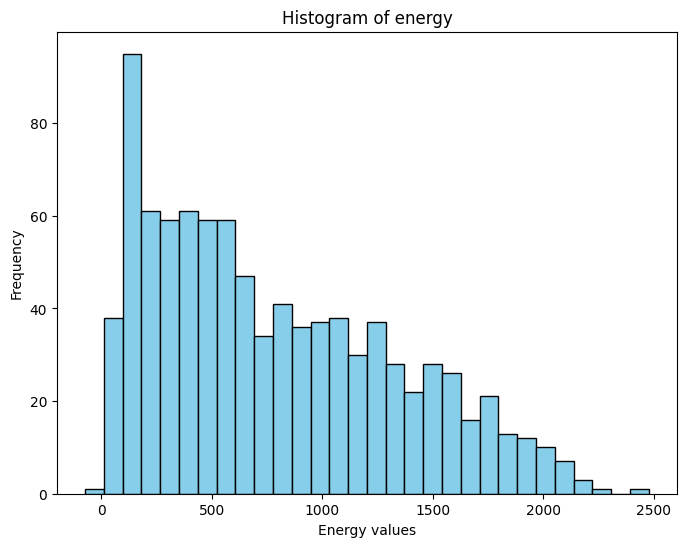

In [58]:
# Plotting a histogram
plt.figure(figsize=(8, 6))
plt.hist(y_test_pred, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of energy')
plt.xlabel('Energy values')
plt.ylabel('Frequency')
plt.show()

We will train the model with the entire data set.

In [ ]:
X_train= pd.DataFrame(X_train_imputed_features, columns=remaining_columns[1:])
data = pd.concat([X_train, X_test_imputed])
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
y = pd.concat([y_train, y_test])

In [ ]:
best_imputer.fit(data)
best_regressor.fit(data, y)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(max_depth=6, max_features='log2',
                          random_state=100505730)

In [ ]:
pred = best_regressor.predict(data)

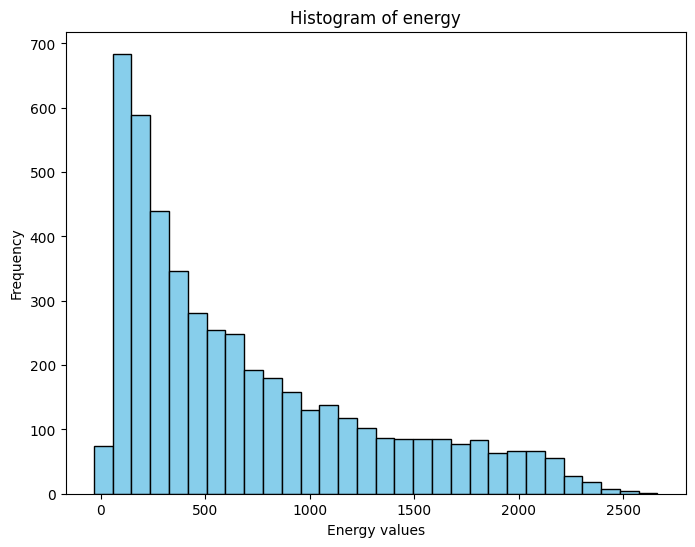

In [ ]:
# Plotting a histogram
plt.figure(figsize=(8, 6))
plt.hist(pred, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of energy')
plt.xlabel('Energy values')
plt.ylabel('Frequency')
plt.show()

We oberve that the distribution behaves as expected.

Saving the model

In [ ]:
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(best_regressor, open(filename, 'wb'))

# Competition data
Once we have trained the final moedl we wil make predictions using the competition data set.

In [ ]:
competition = pd.read_csv(PATH+'wind_competition.csv.gzip', compression="gzip")
competition = competition.to_numpy()

In [ ]:
# Define prefixes to remove
prefixes_to_remove = ['p55.', 'year', 'flsr']

# Get indices of columns to remove based on prefixes
columns_to_remove = [i for i, name in enumerate(column_names) if name.startswith(tuple(prefixes_to_remove))]
competition_del = np.delete(competition, columns_to_remove, axis=1)
competition_scale = scaler.fit_transform(competition_del)
comp_imputed = pipeline.named_steps['imputation'].transform(competition_scale)
predictions = best_regressor.predict(comp_imputed)

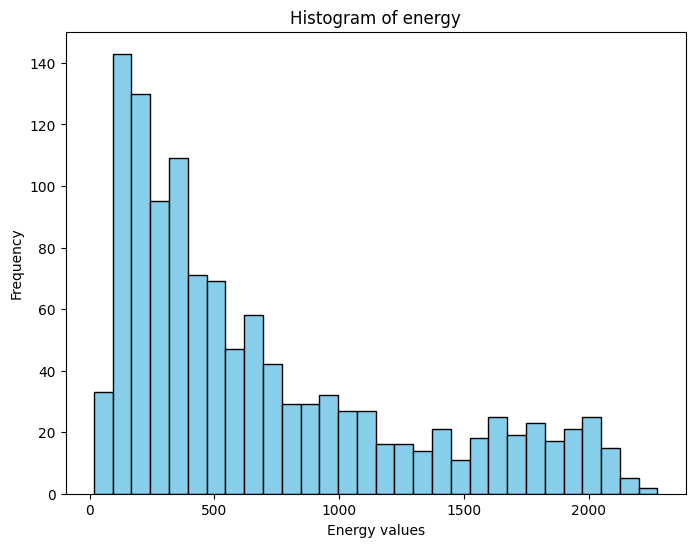

In [ ]:
# Plotting a histogram
plt.figure(figsize=(8, 6))
plt.hist(predictions, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of energy')
plt.xlabel('Energy values')
plt.ylabel('Frequency')
plt.show()

We see that the distribution of energy we obtain behaves similarly to the original energy distribution, so we could expect that the predictions obtained are reasonable in the context of this problem.

We will save the predictions and the model separately.

In [ ]:
#saving predictions to a txt file
# File path where you want to save the predictions
file_path = 'predictions.txt'

# Open the file in write mode and save predictions line by line
with open(file_path, 'w') as file:
    for prediction in predictions:
        file.write(f'{prediction}\n')